In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/tri_rand3/GxC1.txt", anno_dir = "./data/symsim2/tri_rand3/cell_label1.txt", anchor = "6_1")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/tri_rand3/RxC2.txt", anno_dir = "./data/symsim2/tri_rand3/cell_label2.txt")

In [3]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 64, 6], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 256, 64, 6], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    X_tsne1 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_atac_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)
    X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    X_tsne2 = TSNE(n_components = 2).fit_transform(data["count"].numpy())
    X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

Calculating PHATE...
  Running PHATE on 1394 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.21 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.32 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 6.17 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.73 seconds.
Calculated PHATE in 9.38 seconds.
Calculating PHATE...
  Running PHATE on 1392 observations and 3000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.20 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 s

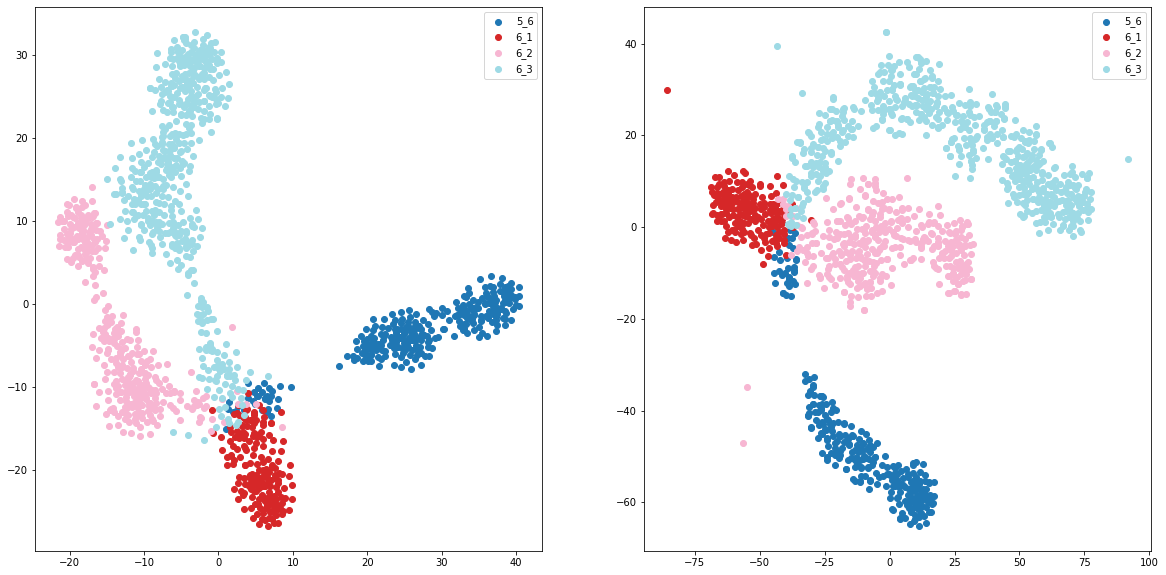

In [4]:
plot_latent(z1 = X_tsne1, z2 = X_tsne2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

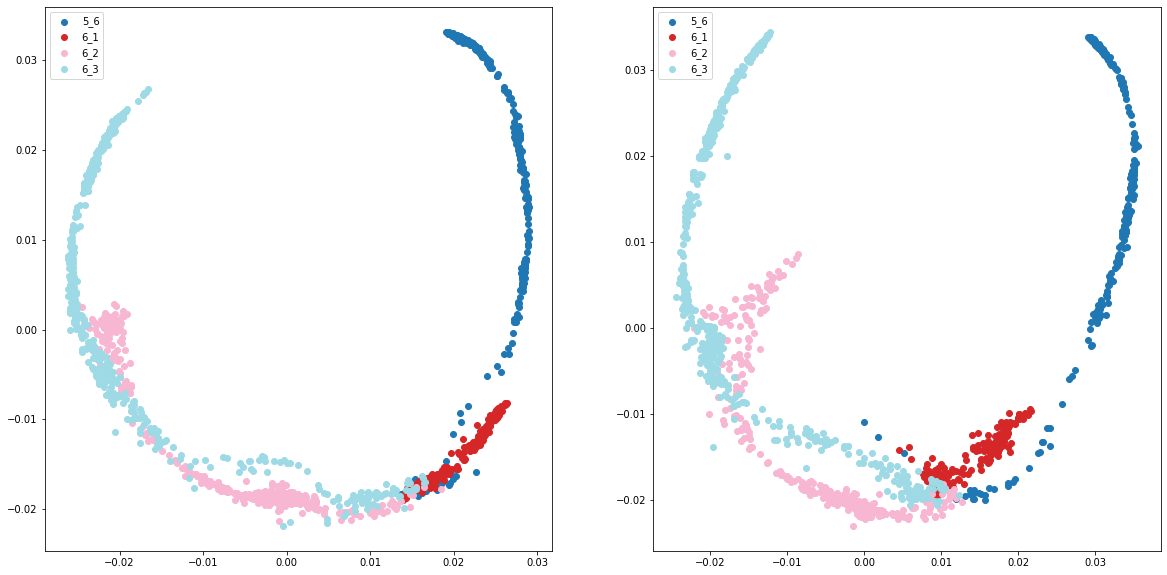

In [5]:
plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [6]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 1e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 1e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)


In [7]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [8]:
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 101, lamb_r1 = 0.5, lamb_r2 = 0.5, dist_mode = "mse")

epoch:  0 RNA recon loss: 22.28630, RNA dist loss: 0.30780 ATAC recon loss: 0.48587, ATAC dist loss: 0.28383
epoch:  10 RNA recon loss: 2.94416, RNA dist loss: 0.09016 ATAC recon loss: 0.04984, ATAC dist loss: 0.10190
epoch:  20 RNA recon loss: 1.72117, RNA dist loss: 0.07896 ATAC recon loss: 0.02974, ATAC dist loss: 0.08426
epoch:  30 RNA recon loss: 1.28848, RNA dist loss: 0.08851 ATAC recon loss: 0.02608, ATAC dist loss: 0.10857
epoch:  40 RNA recon loss: 1.01092, RNA dist loss: 0.07696 ATAC recon loss: 0.01915, ATAC dist loss: 0.08607
epoch:  50 RNA recon loss: 0.86868, RNA dist loss: 0.07649 ATAC recon loss: 0.02136, ATAC dist loss: 0.08821
epoch:  60 RNA recon loss: 0.74946, RNA dist loss: 0.07084 ATAC recon loss: 0.01982, ATAC dist loss: 0.08720
epoch:  70 RNA recon loss: 0.68402, RNA dist loss: 0.07825 ATAC recon loss: 0.01455, ATAC dist loss: 0.08996
epoch:  80 RNA recon loss: 0.61708, RNA dist loss: 0.06850 ATAC recon loss: 0.01471, ATAC dist loss: 0.08126
epoch:  90 RNA reco

In [9]:
# # add recon can help reduce the dist_loss
# utils.pre_train_ae(encoder = encoder1, decoder = decoder1, fusion = fusion, data_loader = train_rna_loader, diff_sim = Diff1, recon_opt = optimizer_rna, dist_opt = optimizer_dist_rna, n_epochs = 101, lambda_r = 1, dist_mode = "mse")

In [10]:
# utils.pre_train_ae(encoder = encoder2, decoder = decoder2, fusion = fusion, data_loader = train_atac_loader, diff_sim = Diff2, recon_opt = optimizer_atac, dist_opt = optimizer_dist_atac,  n_epochs = 101, lambda_r = 1, dist_mode = "mse")

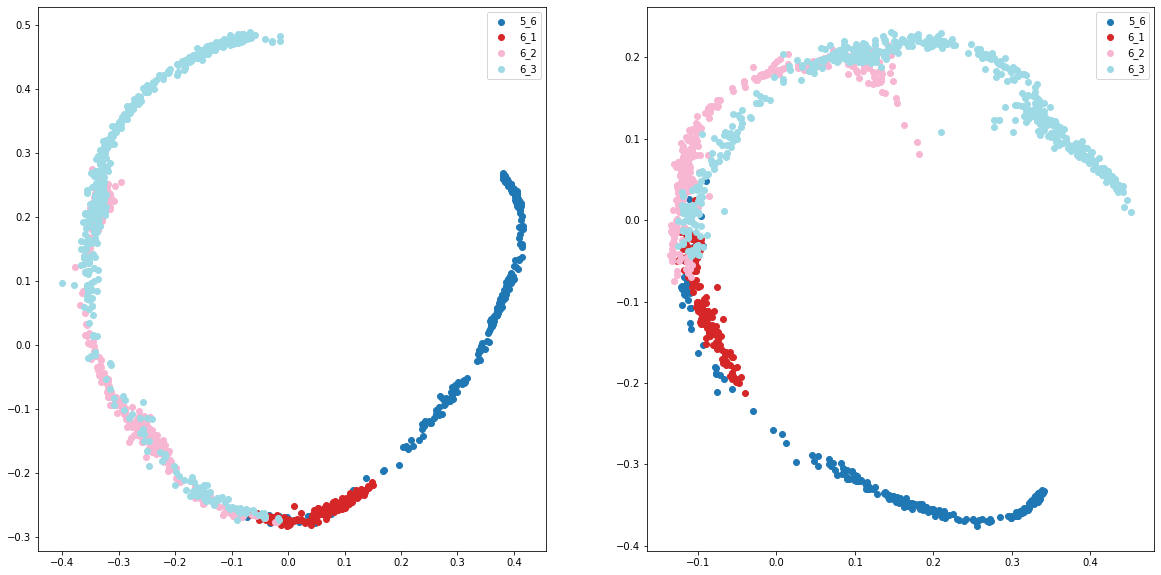

In [11]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [12]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 201, use_anchor = False)

epoch:  0 Discriminator loss: 0.68561
epoch:  10 Discriminator loss: 0.37834
epoch:  20 Discriminator loss: 0.04422
epoch:  30 Discriminator loss: 0.01312
epoch:  40 Discriminator loss: 0.00475
epoch:  50 Discriminator loss: 0.00335
epoch:  60 Discriminator loss: 0.00207
epoch:  70 Discriminator loss: 0.00141
epoch:  80 Discriminator loss: 0.00121
epoch:  90 Discriminator loss: 0.00167
epoch:  100 Discriminator loss: 0.00097
epoch:  110 Discriminator loss: 0.00113
epoch:  120 Discriminator loss: 0.00080
epoch:  130 Discriminator loss: 0.00041
epoch:  140 Discriminator loss: 0.00038
epoch:  150 Discriminator loss: 0.00030
epoch:  160 Discriminator loss: 0.00038
epoch:  170 Discriminator loss: 0.00024
epoch:  180 Discriminator loss: 0.00035
epoch:  190 Discriminator loss: 0.00027
epoch:  200 Discriminator loss: 0.00023


In [11]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=120, n_iter2 = 7, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 1.10983, RNA dist loss: 0.10227 ATAC recon loss: 0.04766, ATAC dist loss: 0.24569 Discriminator loss: 0.79815
epoch:  10 RNA recon loss: 1.04435, RNA dist loss: 0.10726 ATAC recon loss: 0.02327, ATAC dist loss: 0.20179 Discriminator loss: 0.17644
epoch:  20 RNA recon loss: 0.95248, RNA dist loss: 0.11119 ATAC recon loss: 0.01487, ATAC dist loss: 0.17181 Discriminator loss: 0.20489
epoch:  30 RNA recon loss: 0.86739, RNA dist loss: 0.11490 ATAC recon loss: 0.01580, ATAC dist loss: 0.16968 Discriminator loss: 0.36886
epoch:  40 RNA recon loss: 0.81080, RNA dist loss: 0.12054 ATAC recon loss: 0.01720, ATAC dist loss: 0.13514 Discriminator loss: 0.46019
epoch:  50 RNA recon loss: 0.74907, RNA dist loss: 0.11571 ATAC recon loss: 0.01282, ATAC dist loss: 0.15144 Discriminator loss: 0.34505
epoch:  60 RNA recon loss: 0.67690, RNA dist loss: 0.10813 ATAC recon loss: 0.01458, ATAC dist loss: 0.14174 Discriminator loss: 0.37686
epoch:  70 RNA recon loss: 0.64258, RNA di

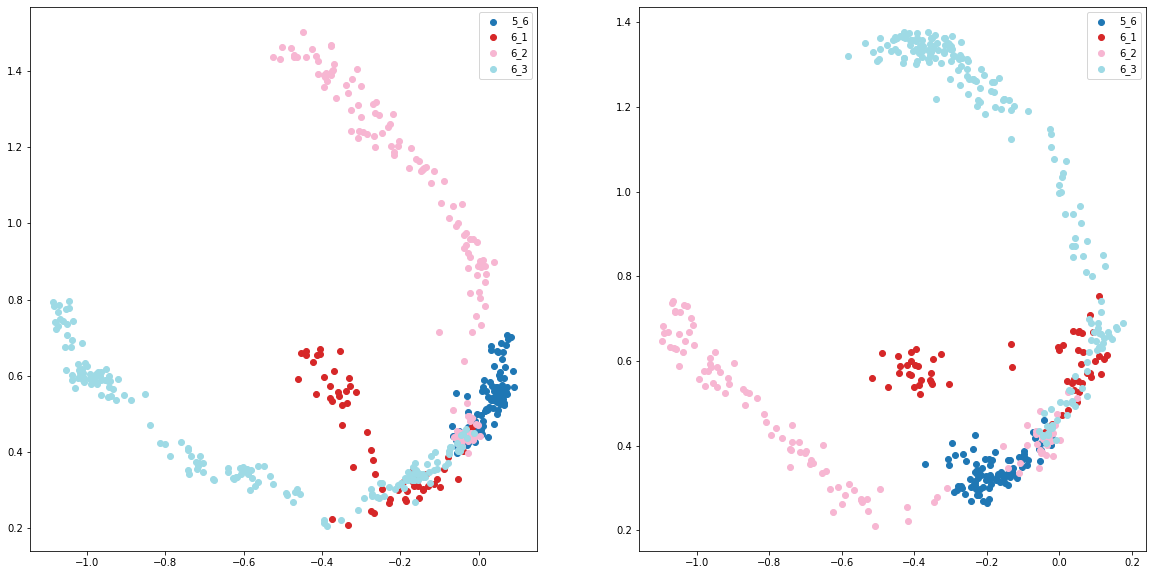

In [12]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

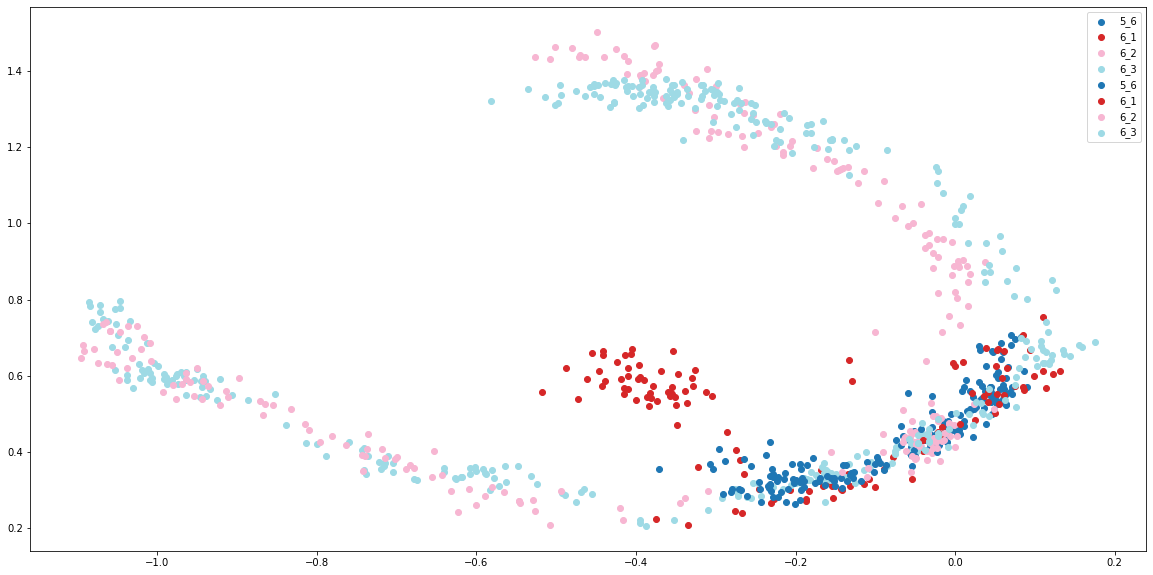

In [13]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)

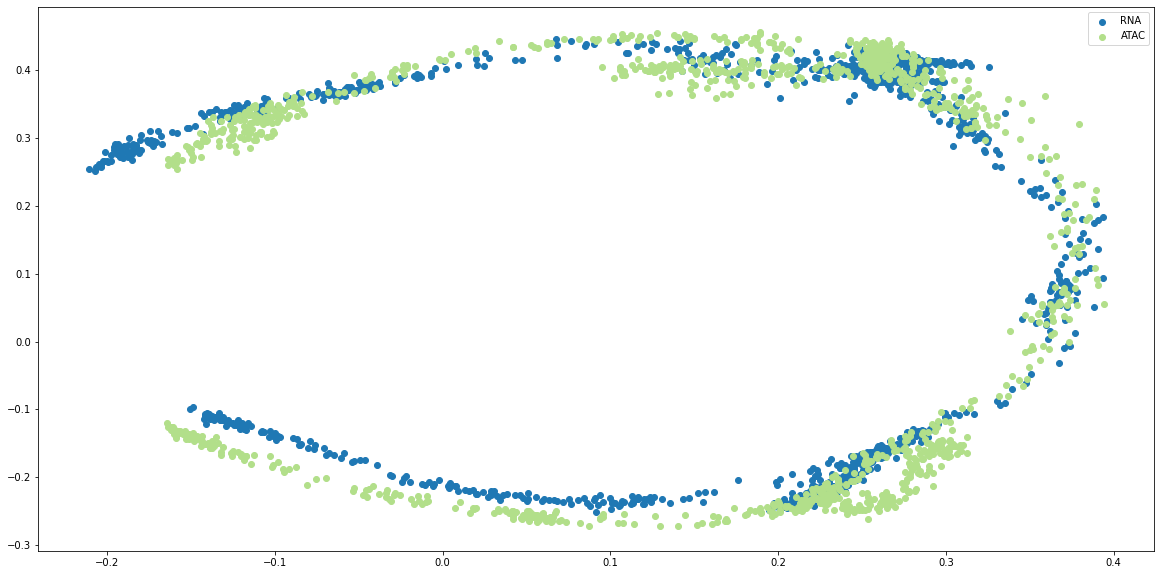

In [20]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)

In [15]:
torch.save({
    'encoder1': encoder1.state_dict(),
    'encoder2': encoder2.state_dict(),
    'disc': disc.state_dict(),
    'fusion': fusion.state_dict(),
    'decoder1': decoder1.state_dict(),
    'decoder2': decoder2.state_dict(),
    'config1': rna_CONFIG,
    'config2': atac_CONFIG,
    'Diff1': Diff1,
    'Diff2': Diff2
}, './saved_model/symsim2.pt')

In [ ]:
# state = torch.load('./saved_model/symsim2.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])